Welcome to our project 2 Development Space

Group memebers: Randy, Bowen and IT

The task is to create some code that will generate the 'climate stripes' for the data held by the Climate Data Online: Web Services (https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted)

![logo](https://www.atmos.illinois.edu/~randyjc2/images/ClimateStripy.png)

*We do NOT own this logo. It was generated here: https://brandmark.io/ 



### Install some packages

In [1]:
!pip install pyproj==1.9.5.1
!apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
!pip install Cython
!pip install cartopy
!pip install metpy

     |████████████████████████████████| 4.4MB 2.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.5.1-cp36-cp36m-linux_x86_64.whl size=3651978 sha256=b61025e49844e0646f1b483cb2353f1233898eb600907dbe7941eb426d0bd6c0
  Stored in directory: /root/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
Successfully built pyproj
Selecting previously unselected package libgeos-dev.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up libproj-dev:amd64 (4.9.3-2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Setting up proj-bin (4.9.3-2) ..

### Main Class code

In [0]:
import requests
import pandas as pd
import time
import tqdm
import numpy as np
import matplotlib.pylab as plt

# move to beginning when merging
import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
# ^^^ move to beginning when merging

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25

class ClimateStripy:
  """ 
  Authors: Randy J. Chase, ENTER YOUR NAME HERE, ENTER YOUR NAME HERE

  Welcome to ClimateStripy! This class is designed to help users create their 
  own "Climate Stripes". See this page for the original idea: 
  https://showyourstripes.info/

  This is the submission to University of Illinois' ATMS 597, Project 2

  What this class can do is:
  1) Find your closest station with TMAX and TMIN long enough to do the stripes 
  (need 1970 - 2000). 

  2) It will go get the daily data and then compute the anomalies, with the 
  choice of timescale (currently supported is Monthly and Yearly, Weekly is a 
  pain because of leap years, and is going to be noisy anyway)
  
  3)Plot the stripes using matplotlib with option to overlay timeseries ontop

  What you will need: 
  1) Token from NCEI;
  https://www.ncdc.noaa.gov/cdo-web/token 

  Python Packages: 
  1) requests
  2) pandas 
  3) time 
  4) tqdm 
  5) pyproj << 2.0 (I use !pip install pyproj==1.9.5.1)
  6) cartopy,metpy *if you want a map 

  """

  def __init__(self,token=None): 
        self.request = None
        self.station = None
        self.station_df = None
        if token is None:
          self.token= None
        if token is not None:
          self.token=token
      
  def find_my_station(self,extent=None,limit=1000,reference_point=None,verbose=True):
    """
    This method will isolate a list of stations within some lat lon box if 
    extent is given. If a reference point is given it will choose the closest, 
    but also return a dataframe with all the stations in a 1by1 degree box.It 
    will make sure there is the required range of data to make the stripes
    (1971 - 2000)

    Inputs: 
    reference_point: list, [lat, lon]
    extent: list, [min_lat,min_lon,max_lat,max_lon]
    verbose: book, spit out the station chosen 

    """

    self.reference_point=reference_point
    if reference_point is None:
      if extent is None:
        print('ERROR: no extent given')
      else:
        request = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&datatypeid=TMIN&datatypeid=TMAX&limit=1000&extent='+str(extent[0])+','+str(extent[1])+','+str(extent[2])+','+str(extent[3]), headers={'token':self.token})
        self.request = request
        list_of_stations = self.request.json()
        df = pd.DataFrame(list_of_stations['results'])
        self.station_df = df
    else:
      extent = [reference_point[0] - 1,reference_point[1]-1,reference_point[0] + 1,reference_point[1]+1]

      extent = [reference_point[0] - 1,reference_point[1]-1,reference_point[0] + 1,reference_point[1]+1]
      request = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&datatypeid=TMIN&datatypeid=TMAX&limit=1000&extent='+str(extent[0])+','+str(extent[1])+','+str(extent[2])+','+str(extent[3]),headers={'token':CS.token})
      self.request = request

      # self.make_request(endpoint='stations',payload={'extent':extent,'limit': limit,'datatypeid': 'TMIN'},token=self.token)
      list_of_stations = self.request.json()
      df = pd.DataFrame(list_of_stations['results'])
      self.station_df = df
      #this is envoke the pyproj package. Please note this must be an old version** < 2.0 
      from pyproj import Proj
      p = Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=reference_point[0], lon_0=reference_point[1])
      x,y = p(self.station_df.longitude.values,self.station_df.latitude.values)
      self.station_df.insert(len(self.station_df.keys()),'distance',np.sqrt(x**2 + y**2)/1000)

      #required time range 1971 - 2000 needed for the mean...
      self.station_df = self.station_df.astype({'mindate': np.datetime64})
      self.station_df = self.station_df.astype({'maxdate': np.datetime64})
      length = (self.station_df.maxdate.values - self.station_df.mindate.values)
      self.station_df.insert(len(self.station_df.keys()),'length_of_record',length)     
      self.station_df = self.station_df.where((self.station_df.mindate < np.datetime64('1971-01-01')))
      self.station_df = self.station_df.where((self.station_df.maxdate > np.datetime64('2000-12-31')))
      #make sure there is good data coverage
      self.station_df = self.station_df.where((self.station_df.datacoverage > 0.8))
      self.station_df = self.station_df.dropna()

      self.reference_point=reference_point
      self.station = self.station_df.loc[pd.Series.idxmin(self.station_df['distance'])]
      self.stationid = self.station.id

      if verbose:
        print('The closes station to your reference point is {} km away'.format(np.round(self.station.distance,2)))
        print('Here is all the station meta data:')
        print(self.station)

  def select_station(self,id=None):
    """ 
    In case you dont like the closest station, you can select a station from the 
    returned station_df
    """

    if id is None: 
      pass
    else:
      temp_df = self.station_df.set_index("id")
      self.station = temp_df.loc[id]
      self.station_id = id

  def mapper(self,zoom=None):
    """ 
    This method will map all the points found in the find_my_station method. It
    uses cartopy, so make sure you have that if you want a map. 
    
    zoom: int, how far you wish to zoom out (if positive). In degrees
    """
    if self.station_df is None: 
      print('ERROR: Please run find_my_station method first')
    else:
      ###import cartopy stuff
      import cartopy
      import cartopy.crs as ccrs
      import cartopy.feature as cfeature
      import matplotlib.ticker as mticker
      from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
      import cartopy.io.shapereader as shpreader
      from cartopy.mpl.geoaxes import GeoAxes
      from mpl_toolkits.axes_grid1 import AxesGrid
      from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
      from metpy.plots import USCOUNTIES
      ###

      #make figure
      fig = plt.figure(figsize=(10, 10))
      #add the map
      ax = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())

      #draw map things 
      ax.add_feature(cfeature.STATES.with_scale('10m'),lw=0.5)
      ax.add_feature(cartopy.feature.OCEAN.with_scale('50m'))
      ax.add_feature(cartopy.feature.LAND.with_scale('50m'), edgecolor='black',lw=0.5,facecolor=[0.95,0.95,0.95])
      ax.add_feature(cartopy.feature.LAKES.with_scale('50m'), edgecolor='black')
      ax.add_feature(cartopy.feature.RIVERS.with_scale('50m'))
      ax.add_feature(USCOUNTIES.with_scale('5m'))

      if zoom is None:
        zoom = 1
      #set corners of the map. 
      corners = [CS.reference_point[1] - zoom,CS.reference_point[1] + zoom,CS.reference_point[0]- zoom,CS.reference_point[0]+ zoom]

      #this set_extent crashes the python session. Not sure why... 
      # ax.set_extent((CS.reference_point[1] - 5,CS.reference_point[1] + 5,CS.reference_point[0]- 2,CS.reference_point[0]+ 2),crs=ccrs.PlateCarree())

      #draw ticks
      ax.set_xticks(np.arange(corners[0], corners[1], 1), crs=ccrs.PlateCarree())
      ax.set_yticks(np.linspace(corners[2], corners[3], 5), crs=ccrs.PlateCarree())
      lon_formatter = LongitudeFormatter(zero_direction_label=True)
      lat_formatter = LatitudeFormatter()
      ax.xaxis.set_major_formatter(lon_formatter)
      ax.yaxis.set_major_formatter(lat_formatter)

      #force bounds
      ax.set_xlim([corners[0],corners[1]])
      ax.set_ylim([corners[2],corners[3]])

      #plot stations colored by distance 
      pm = ax.scatter(self.station_df.longitude,self.station_df.latitude,c=self.station_df.distance,s=(self.station_df.length_of_record.values.astype(int)/3.154e+16)/2,zorder=2)
      plt.colorbar(pm,ax=ax,label='Distance')

      ax.plot(self.reference_point[1],self.reference_point[0],'*k',ms=15,markerfacecolor='w',markeredgewidth=2,zorder=10,label='Reference_point')
      ax.plot(self.station.longitude,self.station.latitude,'sk',ms=10,markerfacecolor='w',markeredgewidth=2,label='Closest_Station')
      ax.legend()

  def select_station(self,id=None):
    """ 
    In case you dont like the closest station, you can select a station from the 
    returned station_df
    """

    if id is None: 
      pass
    else:
      if self.station_df is not None:
        temp_df = self.station_df.set_index("id")
        self.station = temp_df.loc[id]
        self.station_id = id
      else:
        self.station_id = id       
        self.grab_station_info()

  def grab_station_info(self):
    print('Searching for station info. Please be patient.')
    station_found_flag = True
    it = 1
    it2 = 0
    while station_found_flag:
      list_of_stations = (make_request('stations',payload={'limit':'1000','datasetid':'GHCND','offset':str(it),'sortorder':'desc'})).json()
      df = pd.DataFrame(list_of_stations['results'])
      if not df.where(df.id==self.station_id).dropna().empty:
        station_found_flag = False
        print('station found')
        df = df.where(df.id==self.station_id).dropna()
        df = df.astype({'mindate': np.datetime64})
        df = df.astype({'maxdate': np.datetime64})
        self.station = df.iloc[0,:]
        self

      it += 1000
      it2 += 1

      if (it2 > 139):
        print('station not found. please check spelling')
        break 

  def fetch(self):
    """ This method invokes the other method to grab data from the archive"""

    years =  (self.station.maxdate - self.station.mindate).total_seconds()/3.154e+7
    years = np.arange(0,np.round(years,0))
    #to debug, let just do 10 years. 
    # years = np.arange(0,10)

    self.years = years
    self.mindate = self.station.mindate
    self.maxdate = self.station.maxdate
    self.TMIN = None
    self.TMAX = None
    self.kill_flag = False
    self.current = str(self.mindate)
    from tqdm import tqdm
    for i in tqdm(range(len(years))):
        self.fetch_inside()
    
  def fetch_inside(self):
    """ This method grabs the data for some year and some station"""
    station_id = self.station.id
    year = self.current[0:4]
    #make the api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&datatypeid=TMAX&limit=1000&stationid='+station_id+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':self.token})
    #if its empty go to the next year. 
    if len(list(r)) <= 1:
      pass
    else:
      df = pd.DataFrame(r.json()['results'])
      tmax = df.where(df.datatype=='TMAX').dropna(how='all')
      tmin = df.where(df.datatype=='TMIN').dropna(how='all')
      if self.TMIN is None:
        self.TMIN = tmin
        self.TMAX = tmax 
      else:
        self.TMIN = self.TMIN.append(tmin)
        self.TMAX = self.TMAX.append(tmax)

    self.current = str(np.asarray(self.current,dtype=np.datetime64) +np.timedelta64(365,'D'))

  def clean_df(self):
    """ This just cleans up the data a bit """
    series_tmin = pd.Series(self.TMIN.value.values/10, index=pd.DatetimeIndex(self.TMIN.date.astype(np.datetime64)))
    series_tmax = pd.Series(self.TMAX.value.values/10, index=pd.DatetimeIndex(self.TMAX.date.astype(np.datetime64)))

    self.TMIN = series_tmin
    self.TMAX = series_tmax

    idx = pd.date_range(str(self.station.mindate)[0:4]+'-01-01',str(self.station.maxdate)[0:4]+'-12-31')
    self.TMIN = self.TMIN.reindex(idx, fill_value=np.nan)
    self.TMAX = self.TMAX.reindex(idx, fill_value=np.nan)

  def test_data_avail(self):
    """ Double check to see if there is enough data in the 1970 - 2000 time 
    frame to calc anom """
    chunk = self.TMIN[slice('1971-01-01','2000-12-31')].values.shape[0]
    chunk = chunk/(30*365)
    if chunk < 0.8:
      print('ERROR: Data needed for anomaly calculation is too low (<80% there) Please select a different station from self.')
    else:
      print('Data are fine')

  def get_monthly_anom(self):
    count_tmin = self.TMIN.groupby(by=[CS.TMIN.index.year,CS.TMIN.index.month]).count()
    count_tmax = self.TMAX.groupby(by=[CS.TMAX.index.year,CS.TMAX.index.month]).count()

    #resample native daily to monthly 
    self.TMIN_MO = self.TMIN.resample('MS').mean()
    self.TMAX_MO = self.TMAX.resample('MS').mean()
    #get baseline for anomaly calc. 
    self.TMIN_mo = self.TMIN_MO[slice('1971-01-01','2000-12-31')]
    TMIN_baseline =self.TMIN_mo.groupby(by=self.TMIN_mo.index.month).mean()
    TMIN_std = self.TMIN_mo.groupby(by=self.TMIN_mo.index.month).std()
    self.TMIN_MO_anom = self.TMIN_MO.groupby(by=self.TMIN_MO.index.year).apply(calc_anom(TMIN_baseline,TMIN_std))
    self.TMIN_MO_anom = self.TMIN_MO_anom.where(count_tmin.values > (0.8*30)) #make sure 80% of the days are in that month to count 

    self.TMAX_mo = self.TMAX_MO[slice('1971-01-01','2000-12-31')]
    TMAX_baseline =self.TMAX_mo.groupby(by=self.TMAX_mo.index.month).mean()
    TMAX_std = self.TMAX_mo.groupby(by=self.TMAX_mo.index.month).std()
    self.TMAX_MO_anom = self.TMAX_MO.groupby(by=self.TMAX_MO.index.year).apply(calc_anom(TMAX_baseline,TMAX_std))
    self.TMAX_MO_anom = self.TMAX_MO_anom.where(count_tmax.values > (0.8*30)) #make sure 80% of the days are in that month to count 

  def get_yearly_anom(self):
    count_tmin = self.TMIN.groupby(by=[CS.TMIN.index.year]).count()
    count_tmax = self.TMAX.groupby(by=[CS.TMAX.index.year]).count()
    #resample native daily to monthly 
    self.TMIN_YR = self.TMIN.resample('YS').mean()
    self.TMAX_YR = self.TMAX.resample('YS').mean()
    #get baseline for anomaly calc. 
    self.TMIN_yr = self.TMIN_YR[slice('1971-01-01','2000-12-31')]
    TMIN_baseline =self.TMIN_yr.groupby(by=self.TMIN_yr.index.month).mean()
    TMIN_std = self.TMIN_yr.groupby(by=self.TMIN_yr.index.month).std()
    self.TMIN_YR_anom = self.TMIN_YR.groupby(by=self.TMIN_YR.index.year).apply(calc_anom(TMIN_baseline,TMIN_std))
    self.TMIN_YR_anom = self.TMIN_YR_anom.where(count_tmin.values > (0.8*365)) #make sure 80% of the days are in that month to count 

    self.TMAX_yr = self.TMAX_YR[slice('1971-01-01','2000-12-31')]
    TMAX_baseline =self.TMAX_yr.groupby(by=self.TMAX_yr.index.month).mean()
    TMAX_std = self.TMAX_yr.groupby(by=self.TMAX_yr.index.month).std()
    self.TMAX_YR_anom = self.TMAX_YR.groupby(by=self.TMAX_YR.index.year).apply(calc_anom(TMAX_baseline,TMAX_std))
    self.TMAX_YR_anom = self.TMAX_YR_anom.where(count_tmax.values > (0.8*365)) #make sure 80% of the days are in that month to count 

  def draw_my_stripes(self,which='TMAX',method='Y',plot_val=True,savefig=False):

      if method == 'Y':
        if which=='TMAX':
          anomaly = self.TMAX_YR_anom
        else:
          anomaly = self.TMIN_YR_anom
      elif method =='M':
        if which=='TMAX':
          anomaly = self.TMAX_MO_anom
        else:
          anomaly = self.TMIN_MO_anom
      elif method =='W':
        print('Your request could not be met, please choose another method')
      
      date = anomaly.index
      first = mdates.date2num(date[0])
      last = mdates.date2num(date[-1])
      width = (last - first) / (date.size-1)
      [lower, upper] = [anomaly.min() - 0.1, anomaly.max() + 0.1]

      # initialize the plot
      fig = plt.figure(figsize=(11, 1))
      ax = fig.add_axes([0, 0, 1, 1])
      # ax.set_axis_off()

      # create a color map for stripes
      cmap = ListedColormap([
          '#08306b', '#08519c', '#2171b5', '#4292c6',
          '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
          '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
          '#ef3b2c', '#cb181d', '#a50f15', '#67000d',])

      
      patches = [Rectangle((date, lower), width, upper-lower) for date in np.arange(first, last + width,width)]
      ind = np.where(~anomaly.isna())[0]
      patches2 = []
      for i in ind:
        patches2.append(patches[i])

      ind2 = np.where(anomaly.isna())[0]
      patches3 = []
      for i in ind2:
        patches3.append(patches[i])

      # create a collection with a rectangle for each year
      col = PatchCollection(patches2)
      col2 = PatchCollection(patches3,hatch='x',facecolor=[0.75,0.75,0.75],edgecolor='k',lw=0.25)
      # set data, colormap and color limits
      col.set_array(anomaly[ind])
      col.set_cmap(cmap)
      col.set_clim([-2.6,2.6])
      ax.add_collection(col)
      ax.add_collection(col2)

      ax.set_ylim(lower, upper)
      ax.set_xlim(first, last + width)

      ax.set_title(self.station['name'])
      if plot_val:
          ax.plot(date, anomaly, markersize = 8, marker = 'o', linestyle = '--', markerfacecolor='w',color = 'k',path_effects=[path_effects.SimpleLineShadow(),
                        path_effects.Normal()])
      plt.show()
      if savefig:
          fig.savefig('climate-stripes.png')

#function not a method
def calc_anom(baseline,std):
    def calc_anom_(x):
        return (x-baseline.values)/std.values
    return calc_anom_


### Example Usage

Below is an example of how to run it!

The first function find_my_station() will find the closest station to some lat/lon reference point. For example we chose campus. 

In [285]:
%pylab inline

#this is Randy's token. Don't abuse it. 
CS = ClimateStripy(token='ngsGbohmGghZztYTsXShLLYNKftmWyps')
#lets choose the station closest to campus. 
CS.find_my_station(reference_point=[40.1020,-88.2272])

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The closes station to your reference point is 2.29 km away
Here is all the station meta data:
elevation                          219.8
mindate              1902-08-01 00:00:00
maxdate              2020-02-10 00:00:00
latitude                          40.084
name                CHAMPAIGN 3 S, IL US
datacoverage                      0.9988
id                     GHCND:USC00118740
elevationUnit                     METERS
longitude                       -88.2404
distance                         2.29385
length_of_record     42927 days 00:00:00
Name: 49, dtype: object


The output that is spit out shows all the metadata associated with the closest station. 

What you can do once you run find_my_station is you can look at all the closest stations by running the .mapper() method

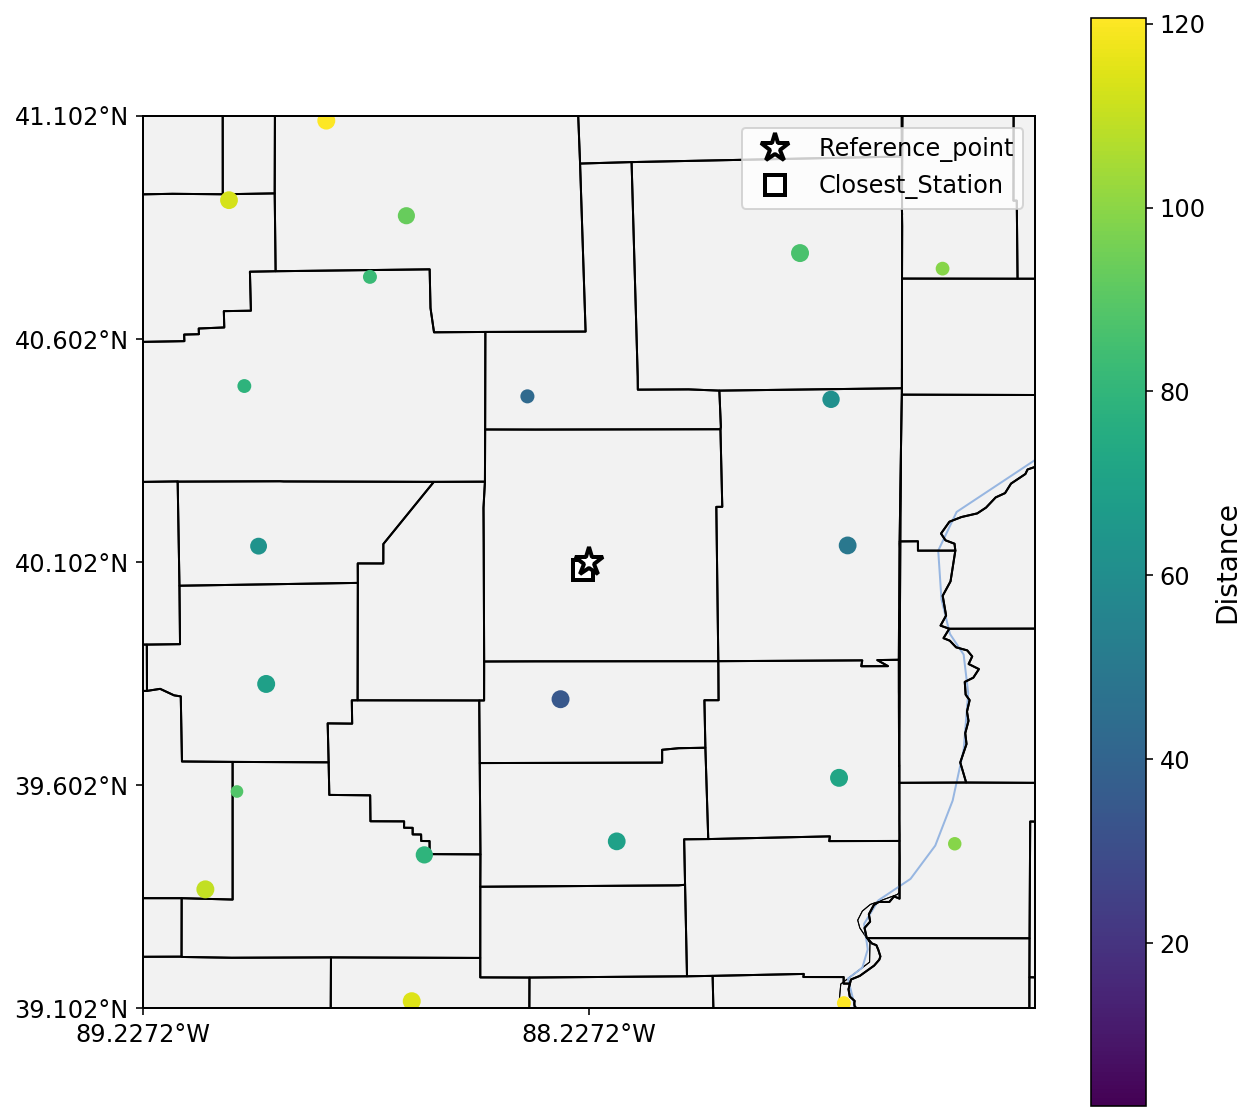

In [290]:
%config InlineBackend.figure_format = 'retina'
CS.mapper()

If you would rather look at them all in list form you can print out the dataframe like so

In [294]:
CS.station_df.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,distance,length_of_record
3,233.5,1949-09-01,2020-02-10,40.49620,"BLOOMINGTON WATERWORKS, IL US",0.9551,GHCND:USC00110761,METERS,-88.99940,78.906096,25729 days
7,213.4,1896-01-01,2020-02-07,39.47620,"CHARLESTON, IL US",0.9631,GHCND:USC00111436,METERS,-88.16520,69.685589,45327 days
8,219.2,1948-06-01,2019-12-31,40.74076,"CHENOA, IL US",0.9533,GHCND:USC00111475,METERS,-88.71802,82.255890,26145 days
11,210.3,1910-01-01,2020-02-10,40.13750,"CLINTON 1 SSW, IL US",0.9763,GHCND:USC00111743,METERS,-88.96750,63.229307,40217 days
13,169.2,1895-04-23,2020-02-09,40.13910,"DANVILLE, IL US",0.9320,GHCND:USC00112140,METERS,-87.64790,49.552999,45582 days


Now that we have a station, we can go get the data with the .fetch() method. This will use the token you provided to intitalize the instance and grab the TMAX and TMIN data for your station. This can sometimes take 5-10 mins, so be patient. 

In [295]:
CS.fetch()

100%|██████████| 118/118 [00:48<00:00,  2.66it/s]


What .fetch does is return a dataframe of the TMIN and TMAX data. Lets take a look 

In [297]:
CS.TMIN.head

<bound method NDFrame.head of                     date datatype            station attributes  value
1    1902-08-01T00:00:00     TMIN  GHCND:USC00118740       ,,6,  167.0
3    1902-08-02T00:00:00     TMIN  GHCND:USC00118740       ,,6,  183.0
5    1902-08-03T00:00:00     TMIN  GHCND:USC00118740       ,,6,  211.0
7    1902-08-04T00:00:00     TMIN  GHCND:USC00118740       ,,6,  183.0
9    1902-08-05T00:00:00     TMIN  GHCND:USC00118740       ,,6,  183.0
..                   ...      ...                ...        ...    ...
721  2019-12-27T00:00:00     TMIN  GHCND:USC00118740   ,,7,2400    6.0
723  2019-12-28T00:00:00     TMIN  GHCND:USC00118740   ,,7,2400    0.0
725  2019-12-29T00:00:00     TMIN  GHCND:USC00118740   ,,7,2400   44.0
727  2019-12-30T00:00:00     TMIN  GHCND:USC00118740   ,,7,2400   -6.0
729  2019-12-31T00:00:00     TMIN  GHCND:USC00118740   ,,7,2400  -11.0

[42834 rows x 5 columns]>

 you can see there is some extra junk in the file we dont need. So lets run the .clean_df() method

In [0]:
CS.clean_df()


In [299]:
CS.TMIN

1902-01-01   NaN
1902-01-02   NaN
1902-01-03   NaN
1902-01-04   NaN
1902-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Freq: D, Length: 43465, dtype: float64

Now we can see all the data has been cleaned up, and missing datapoints have been filled with NaNs. 

Before we calculate the anomalies, we need to make sure that there is good data where the anomaly statistics are based off of (1970-2000). To do this, we have a .test_data_avail() method that will make sure there is at least 80% good data in that range. 

In [300]:
CS.test_data_avail()

Data are fine


Great! We are good to go. Now we can go ahead and calcualte the anomalies, both the monthly and yearly. We chose not to do weekly calcualtions because the result will be very noisey. 

In [0]:
CS.get_monthly_anom()
CS.get_yearly_anom()

Now that we have calculated everything we can draw our climate stripes. By default the .draw_my_stripes() will use TMAX and the yearly anomaly. 

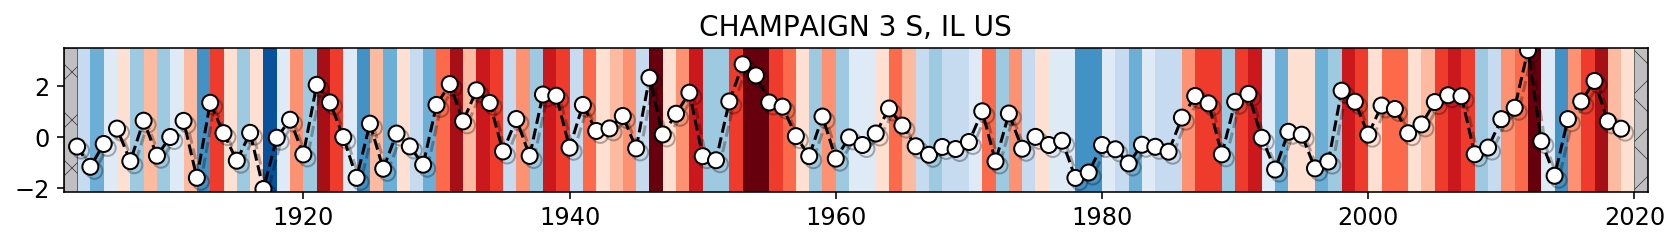

In [302]:
CS.draw_my_stripes()

You can change this like so, lets do the TMIN monthly 

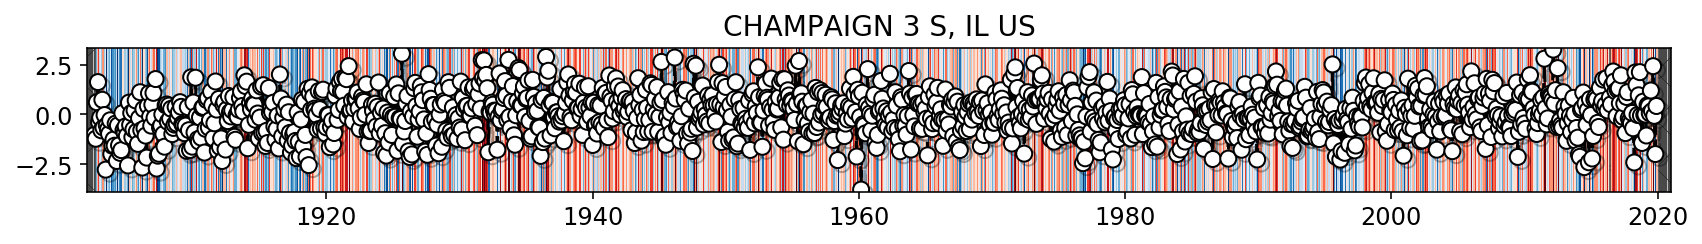

In [304]:
CS.draw_my_stripes(which='TMIN',method='M')